# A demo for training NNF model

## 可以任意尝试Filter_utils里的Filterx, 我们实验的结果是Filter5效果最好，也鼓励大家进行任何形式的魔改

In [2]:
# author: SaKuRa Pop
# data: 2023/3/27 10:21
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pickle
import torch.utils.data as Data
import matplotlib.pyplot as plt
from FilterNet_utils import array_to_tensor, Data_set, training_3, Filter5
import time
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

In [3]:
def smoothing(array, threshold=0.5):
    anomaly_indices = np.where(array < threshold)
    array = np.delete(array, anomaly_indices)
    return array


def smoothing_n_comparision(array, label, threshold=0.5):
    anomaly_indices = np.where(array < threshold)
    array = np.delete(array, anomaly_indices)
    label = np.delete(label, anomaly_indices)
    return array, label


def compute_snr(pure_signal, noisy_signal):
    signal_to_noise_ratio = 10 * (np.log10(np.std(pure_signal)/np.std(noisy_signal-pure_signal)))
    return signal_to_noise_ratio

In [5]:
if __name__ == "__main__":
    """模拟数据 （透射谱）"""
    no_noise_path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\深度学习滤波器\1000组模拟数据\提供给模型的数据\模拟数据\CH_nonoise_spectral.npy"
    CH4_no_noise_spectral = np.load(no_noise_path)  # (1000, 1111) 透射谱（吸收谱）标签
    CH4_no_noise_spectral = array_to_tensor(CH4_no_noise_spectral)

    noisy_path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\深度学习滤波器\1000组模拟数据\提供给模型的数据\模拟数据\CH_noisy_spectral.npy"
    CH4_noisy_spectral = np.load(noisy_path)  # (1000, 1111) 透射谱（吸收谱） input数据
    CH4_noisy_spectral = array_to_tensor(CH4_noisy_spectral)

    train_data, test_data, train_label, test_label = train_test_split(CH4_noisy_spectral,
                                                                      CH4_no_noise_spectral,
                                                                      test_size=0.2,
                                                                      random_state=2)
    train_loader = Data_set(CH4_noisy_spectral, CH4_no_noise_spectral, 100)

    """生成模型实例"""
    Gpu = torch.device("cuda")
    # filter_net = Filter().to(Gpu)
    filter_net = Filter5().to(Gpu)  # which Filter to train
    """定义criterion, optimizer"""
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(filter_net.parameters(), lr=0.0001)

epoch: 0 [0/1000 0.00%] train loss: 0.9042883515357971  test loss: 0.9044253826141357
epoch: 0 [100/1000 10.00%] train loss: 0.874040961265564  test loss: 0.873673141002655
epoch: 0 [200/1000 20.00%] train loss: 0.8423281311988831  test loss: 0.8433246612548828
epoch: 0 [300/1000 30.00%] train loss: 0.813774824142456  test loss: 0.8127700090408325
epoch: 0 [400/1000 40.00%] train loss: 0.7824830412864685  test loss: 0.7817838191986084
epoch: 0 [500/1000 50.00%] train loss: 0.7548560500144958  test loss: 0.7552310228347778
epoch: 0 [600/1000 60.00%] train loss: 0.7299254536628723  test loss: 0.7285822033882141
epoch: 0 [700/1000 70.00%] train loss: 0.7053332924842834  test loss: 0.7049528360366821
epoch: 0 [800/1000 80.00%] train loss: 0.6832349300384521  test loss: 0.6832361817359924
epoch: 0 [900/1000 90.00%] train loss: 0.6645183563232422  test loss: 0.6637651920318604
epoch: 1 [0/1000 0.00%] train loss: 0.6466983556747437  test loss: 0.6466261744499207
epoch: 1 [100/1000 10.00%] tra

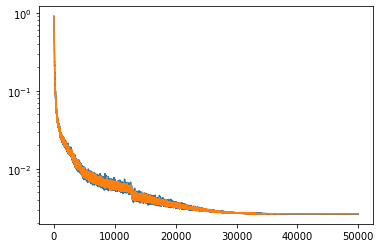

In [7]:
 """训练模型"""
begin_time = time.time()
train_loss, test_loss = training_3(filter_net, train_loader,
                                   test_data, test_label, Gpu, optimizer,
                                   criterion, epochs=5000)
end_time = time.time()
total_time_cost = (end_time - begin_time) / 60
print("总训练用时：{} 分钟".format(total_time_cost))
print("总时长：{} 小时".format(total_time_cost/60.0))

plt.figure()
plt.yscale("log")
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.show()

## 挑一个光谱出来 看看效果

## Pick one test spectrum to check the performance out

(1111,)


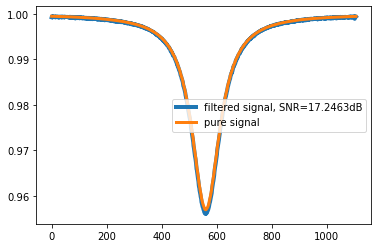

In [8]:
index1 = 900
test_sample_data = CH4_noisy_spectral[index1].reshape(1, 1111).to(Gpu)  # torch.Size([1, 1111])
test_sample_label = CH4_no_noise_spectral[index1].cpu().detach().numpy()
filter_net = filter_net.to(Gpu)
rec_sample_data = filter_net(test_sample_data)
rec_sample_data = rec_sample_data.cpu().detach().numpy()  # <class 'numpy.ndarray'> (1, 1111)
rec_sample_data = np.squeeze(rec_sample_data)  #  (1111,)
rec_sample_data1, label1 = smoothing_n_comparision(rec_sample_data, test_sample_label)
print(rec_sample_data.shape)

plt.figure()
SNR = compute_snr(label1, rec_sample_data1)
plt.plot(rec_sample_data1, linewidth=4, label="filtered signal, SNR={:.4f}dB".format(SNR))
plt.plot(label1, linewidth=3, label="pure signal")
plt.legend()

## 保存模型 save the model

这里我就不再演示了 可自行运行代码
Here I will not run the demo, please feel free to play with it

In [ ]:
"""保存模型"""
model_save_path = r"D:\PYHTON\python3.7\DeepLearningProgram\深度学习滤波器\滤波模型\透射谱的滤波模型\DNN_filter1.pt"
torch.save(filter_net.state_dict(), model_save_path)
print("saved finished ")